In [6]:
'''Trains a Bidirectional LSTM on the IMDB sentiment classification task.
Output after 4 epochs on CPU: ~0.8146
Time per epoch on CPU (Core i7): ~150s.
'''

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # 为了复现
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.datasets import imdb

In [2]:
max_features = 5000  # 保留词数
maxlen = 400  # 每篇文章的最大长度
batch_size = 32
embedding_dims = 50  # 嵌入层维度
nb_filter = 250  # 过滤器的数目
filter_length = 3  # 过滤器的维度
hidden_dims = 250  # 全连层隐藏层单元数
nb_epoch = 10  # epoch

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)


In [3]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen,
                    dropout=0.2))
# 400 * 50
# 卷积核实际上是：3 * 50
# 卷积以后是一个维度为 398 的一维向量
# 250 个卷积核，那么就是 250 个维度为 398 的一维向量
# 经过全局平均池化以后，每个 398 维的一维向量得到一个实数，所以全局平均池化以后得到一个 250 维的向量
model.add(Convolution1D(nb_filter=nb_filter,  # 卷积核个数
                        filter_length=filter_length,  # 卷积核维数
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))  # 全连层
model.add(Dropout(0.2))  # 防止过拟合
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251   

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=250, kernel_size=3, strides=1, padding="valid")`


In [4]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [7]:
class LossHistory(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def plot_loss(self, loss_type='epoch'):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc='upper right')
        plt.show()

history = LossHistory()

In [8]:
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=[x_test, y_test],
          callbacks=[history])

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 6s 245us/step - loss: 0.3901 - acc: 0.8105 - val_loss: 0.2703 - val_acc: 0.8858
Epoch 2/15
25000/25000 [==============================] - 4s 150us/step - loss: 0.2006 - acc: 0.9232 - val_loss: 0.2553 - val_acc: 0.8938
Epoch 3/15
25000/25000 [==============================] - 4s 150us/step - loss: 0.1089 - acc: 0.9621 - val_loss: 0.3101 - val_acc: 0.8839
Epoch 4/15
25000/25000 [==============================] - 4s 150us/step - loss: 0.0442 - acc: 0.9862 - val_loss: 0.4186 - val_acc: 0.8810
Epoch 5/15
25000/25000 [==============================] - 4s 150us/step - loss: 0.0247 - acc: 0.9920 - val_loss: 0.4470 - val_acc: 0.8852
Epoch 6/15
25000/25000 [==============================] - 4s 150us/step - loss: 0.0199 - acc: 0.9934 - val_loss: 0.5307 - val_acc: 0.8812
Epoch 7/15
25000/25000 [==============================] - 4s 150us/step - loss: 0.0204 - acc: 0.9926 - val_loss: 

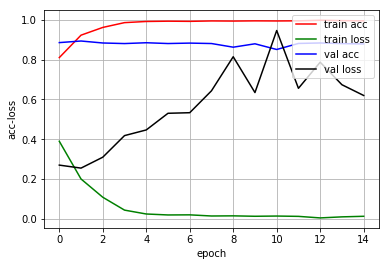

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
history.plot_loss('epoch')

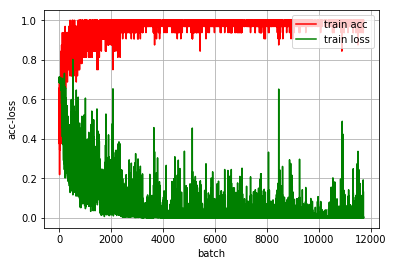

In [11]:
history.plot_loss('batch')